In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3

import warnings
warnings.filterwarnings("ignore")

1. Load Data

In [3]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [4]:
tr_df = train_df('./kaggle')

In [5]:
tr_df

,Class Path,Class
0,./kaggle\anger\-win-holding-his-fists-shout-wo...,anger
1,./kaggle\anger\g2818sb7780bmkdapg.jpg,anger
2,./kaggle\anger\g3ry3pkr1npzzhoetl.jpg,anger
3,./kaggle\anger\g417hk78zy2bj09kk9.jpg,anger
4,./kaggle\anger\g42xe2t4ugw8a2pq4w.jpg,anger
...,...,...
663,./kaggle\sad\little-girl-facial-expressions.jpg,sad
664,./kaggle\sad\low-key-portrait-of-red-haired-wo...,sad
665,./kaggle\sad\middle-aged-woman-relaxed-outdoor...,sad
666,./kaggle\sad\monochrome-portrait-of-a-poor-tee...,sad


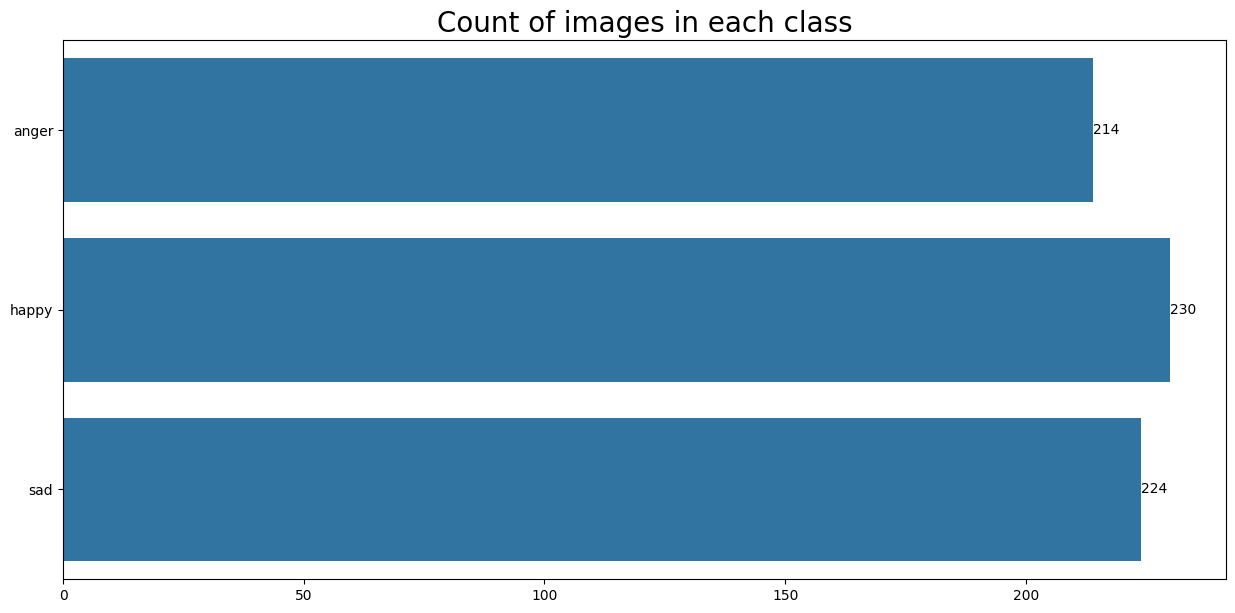

In [6]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

2. Split data into train, test and valid

In [7]:
tr_df, ts_df = train_test_split(tr_df,  train_size= 0.8, shuffle= True, random_state= 20)
valid_df, ts_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 20)

In [8]:
valid_df

,Class Path,Class
261,./kaggle\happy\portrait-of-a-beautiful-hispani...,happy
366,./kaggle\happy\smiling-man-outdoors-in-the-cit...,happy
52,./kaggle\anger\gog1i3qqqj2cm5jiuc.jpg,anger
353,./kaggle\happy\smiles_44.jpg,happy
320,./kaggle\happy\senior-man-smiling-at-home.jpg,happy
...,...,...
319,./kaggle\happy\senior-care-hug-and-portrait-of...,happy
281,./kaggle\happy\portrait-of-adult-bald-smiling-...,happy
182,./kaggle\anger\studio-portrait-of-a-senior-wom...,anger
56,./kaggle\anger\gr58mgnatvb8u7gkac.jpg,anger


3. Preprocessing

In [9]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (224, 224, 3)

gen = ImageDataGenerator(rotation_range=30,
                         shear_range=.1,
                         zoom_range=.1,
                         horizontal_flip=True)


ts_gen = ImageDataGenerator()

tr_gen = gen.flow_from_dataframe(tr_df, x_col= 'Class Path',
                                 y_col= 'Class', target_size= img_size,
                                 color_mode= 'rgb', shuffle= True,
                                 batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col= 'Class Path',
                                    y_col= 'Class', target_size= img_size,
                                    color_mode= 'rgb', shuffle= True,
                                    batch_size= batch_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col= 'Class Path',
                                 y_col= 'Class', target_size= img_size,
                                 color_mode= 'rgb', shuffle= False,
                                 batch_size= batch_size)

Found 534 validated image filenames belonging to 3 classes.
Found 67 validated image filenames belonging to 3 classes.
Found 67 validated image filenames belonging to 3 classes.


In [19]:
labels = {value: key for key, value in tr_gen.class_indices.items()}

print("Classes present in datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Classes present in datasets

0 : anger
1 : happy
2 : sad


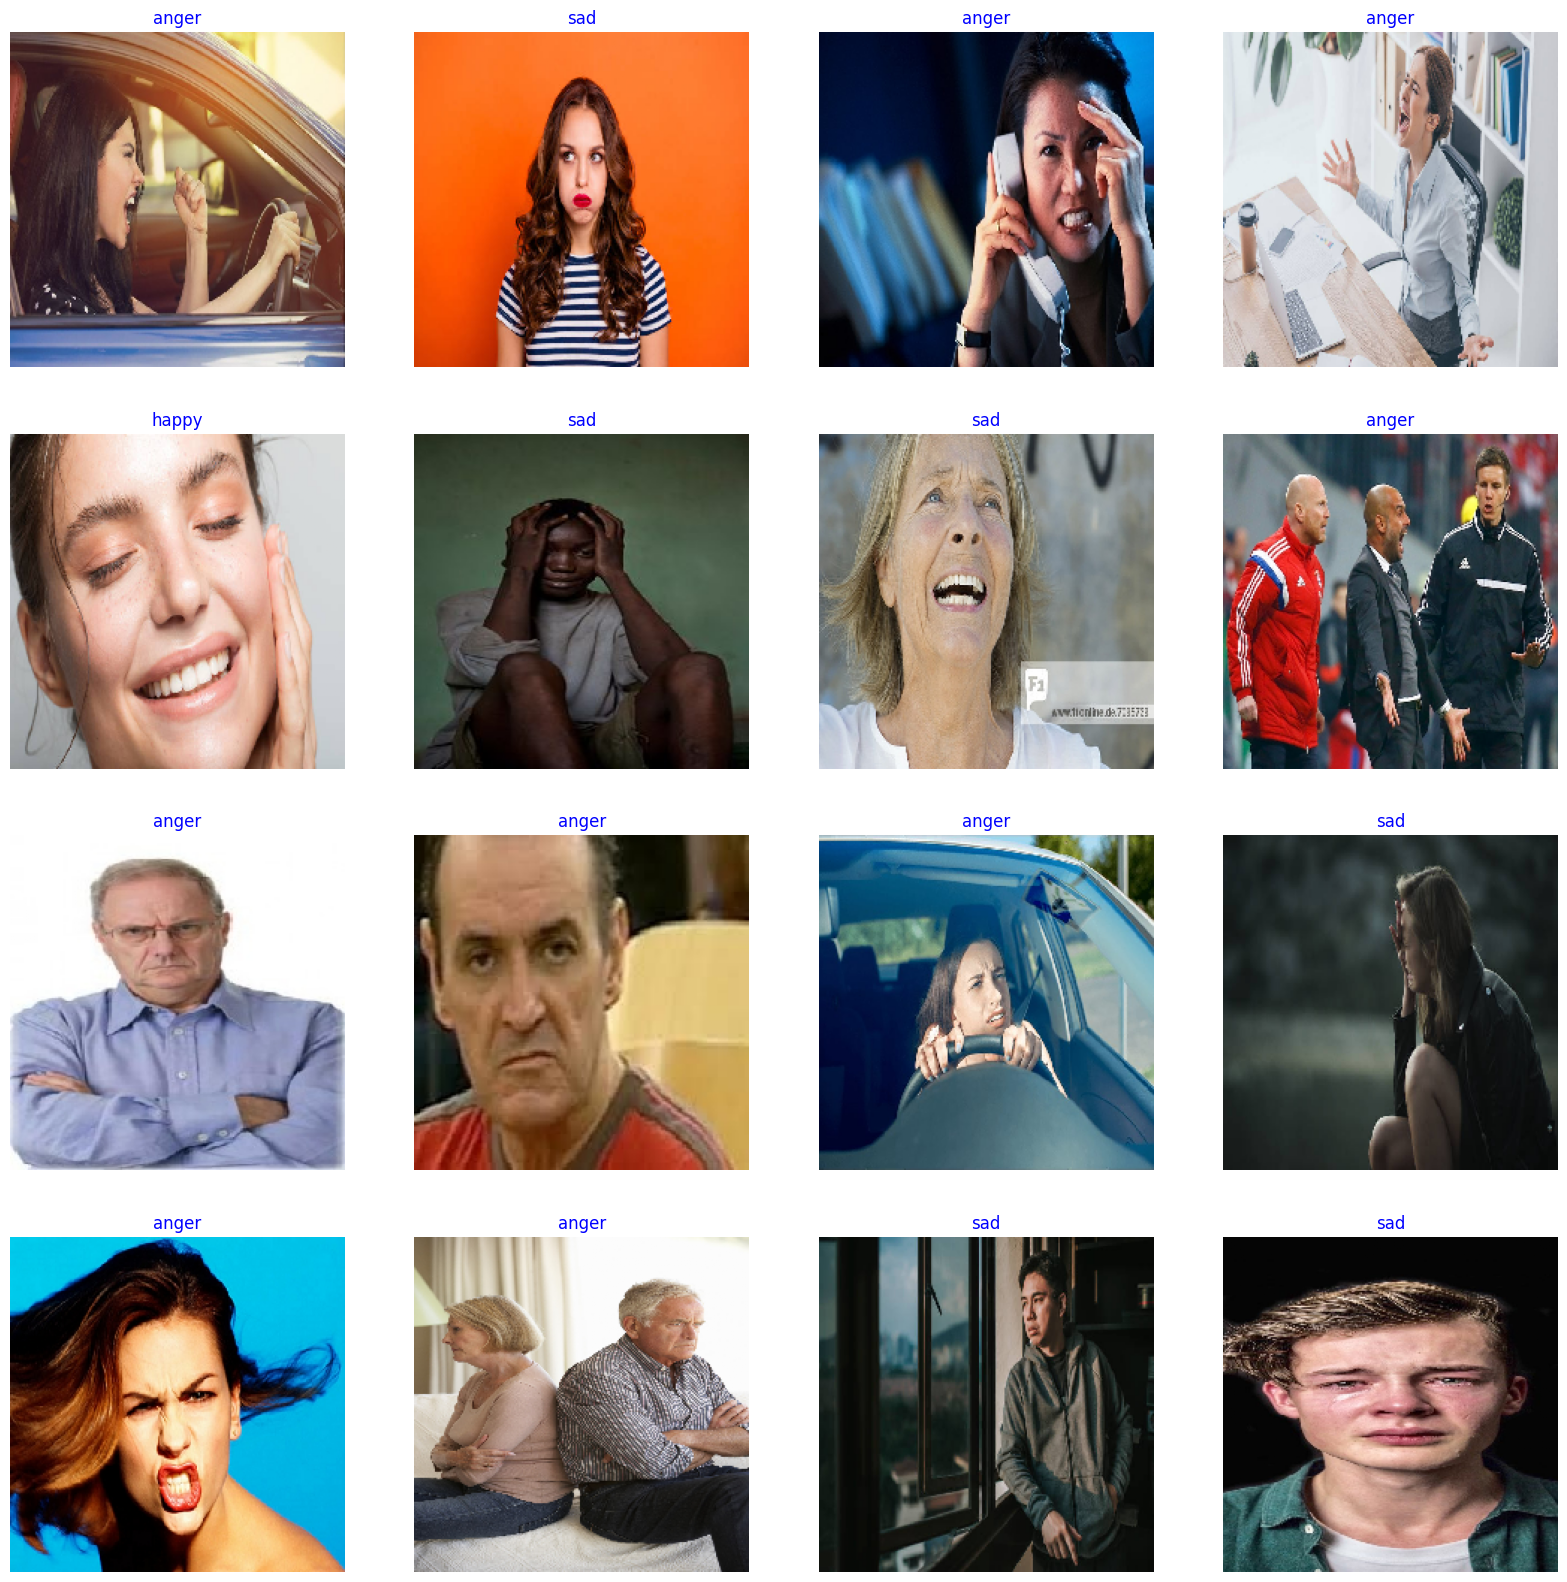

In [10]:
g_dict = tr_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(ts_gen) 

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

4. Build Deep Learning Model

In [11]:
base_model = EfficientNetB3(include_top=False, weights="imagenet",
                      input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Dense(512,activation= 'relu'),
    Dropout(rate= 0.40, seed= 20),
    Dense(3, activation= 'softmax')
])

for layer in base_model.layers:
    layer.trainable = False
    

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,572,018 (44.14 MB)

 Trainable params: 788,483 (3.01 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [12]:
for layer in base_model.layers[1000:]:
    layer.trainable = True
    
model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,572,018 (44.14 MB)

 Trainable params: 788,483 (3.01 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [13]:
for layer in base_model.layers:
    layer.trainable = True
    
model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,572,018 (44.14 MB)

 Trainable params: 11,484,715 (43.81 MB)

 Non-trainable params: 87,303 (341.03 KB)

5. Train

In [14]:
logdir='logs'

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [16]:
#     layer.trainable = False
hist = model.fit(tr_gen, epochs=10, validation_data=valid_gen,
                  callbacks=[tensorboard_callback])

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.4257 - loss: 4.9080 - precision_2: 0.4244 - recall_2: 0.4217 - val_accuracy: 0.6269 - val_loss: 1.0630 - val_precision_2: 0.6333 - val_recall_2: 0.5672
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.5932 - loss: 1.5884 - precision_2: 0.5976 - recall_2: 0.5776 - val_accuracy: 0.5672 - val_loss: 1.5554 - val_precision_2: 0.5846 - val_recall_2: 0.5672
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.7232 - loss: 0.7158 - precision_2: 0.7260 - recall_2: 0.7011 - val_accuracy: 0.7612 - val_loss: 0.8945 - val_precision_2: 0.7846 - val_recall_2: 0.7612
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.8175 - loss: 0.4884 - precision_2: 0.8398 - recall_2: 0.8007 - val_accuracy: 0.7164 - val_loss: 1.0580 - val_precision_2: 0.7273 - val_recall_2: 0.7164
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.8514 - loss: 0.3424 - precision_2: 0.8666 - recall_2: 0.8475 - val_

In [17]:
# layer.trainable[200: ] = True
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=[tensorboard_callback])

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9720 - loss: 0.0884 - precision_2: 0.9720 - recall_2: 0.9717 - val_accuracy: 0.7910 - val_loss: 1.0592 - val_precision_2: 0.8030 - val_recall_2: 0.7910
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9713 - loss: 0.0939 - precision_2: 0.9721 - recall_2: 0.9656 - val_accuracy: 0.8209 - val_loss: 0.8307 - val_precision_2: 0.8333 - val_recall_2: 0.8209
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9651 - loss: 0.1144 - precision_2: 0.9659 - recall_2: 0.9615 - val_accuracy: 0.8060 - val_loss: 0.8437 - val_precision_2: 0.8060 - val_recall_2: 0.8060
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9598 - loss: 0.1073 - precision_2: 0.9598 - recall_2: 0.9598 - val_accuracy: 0.7761 - val_loss: 1.0592 - val_precision_2: 0.7879 - val_recall_2: 0.7761
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9683 - loss: 0.1236 - precision_2: 0.9689 - recall_2: 0.9621 - val_

In [20]:
# layer.trainable = True
hist = model.fit(tr_gen,
                 epochs=12,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=[tensorboard_callback])

Epoch 1/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.9822 - loss: 0.0474 - precision_2: 0.9822 - recall_2: 0.9822 - val_accuracy: 0.7612 - val_loss: 1.0925 - val_precision_2: 0.7612 - val_recall_2: 0.7612
Epoch 2/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9913 - loss: 0.0320 - precision_2: 0.9913 - recall_2: 0.9913 - val_accuracy: 0.7910 - val_loss: 1.2961 - val_precision_2: 0.7910 - val_recall_2: 0.7910
Epoch 3/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9665 - loss: 0.0604 - precision_2: 0.9665 - recall_2: 0.9655 - val_accuracy: 0.7612 - val_loss: 1.0483 - val_precision_2: 0.7612 - val_recall_2: 0.7612
Epoch 4/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.9795 - loss: 0.0424 - precision_2: 0.9807 - recall_2: 0.9789 - val_accuracy: 0.8209 - val_loss: 0.8486 - val_precision_2: 0.8209 - val_recall_2: 0.8209
Epoch 5/12
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9789 - loss: 0.0566 - precision_2: 0.9789 - recall_2: 0.9780 - val_

6. Plot Performance

In [21]:
print(hist.history.keys())

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2'])


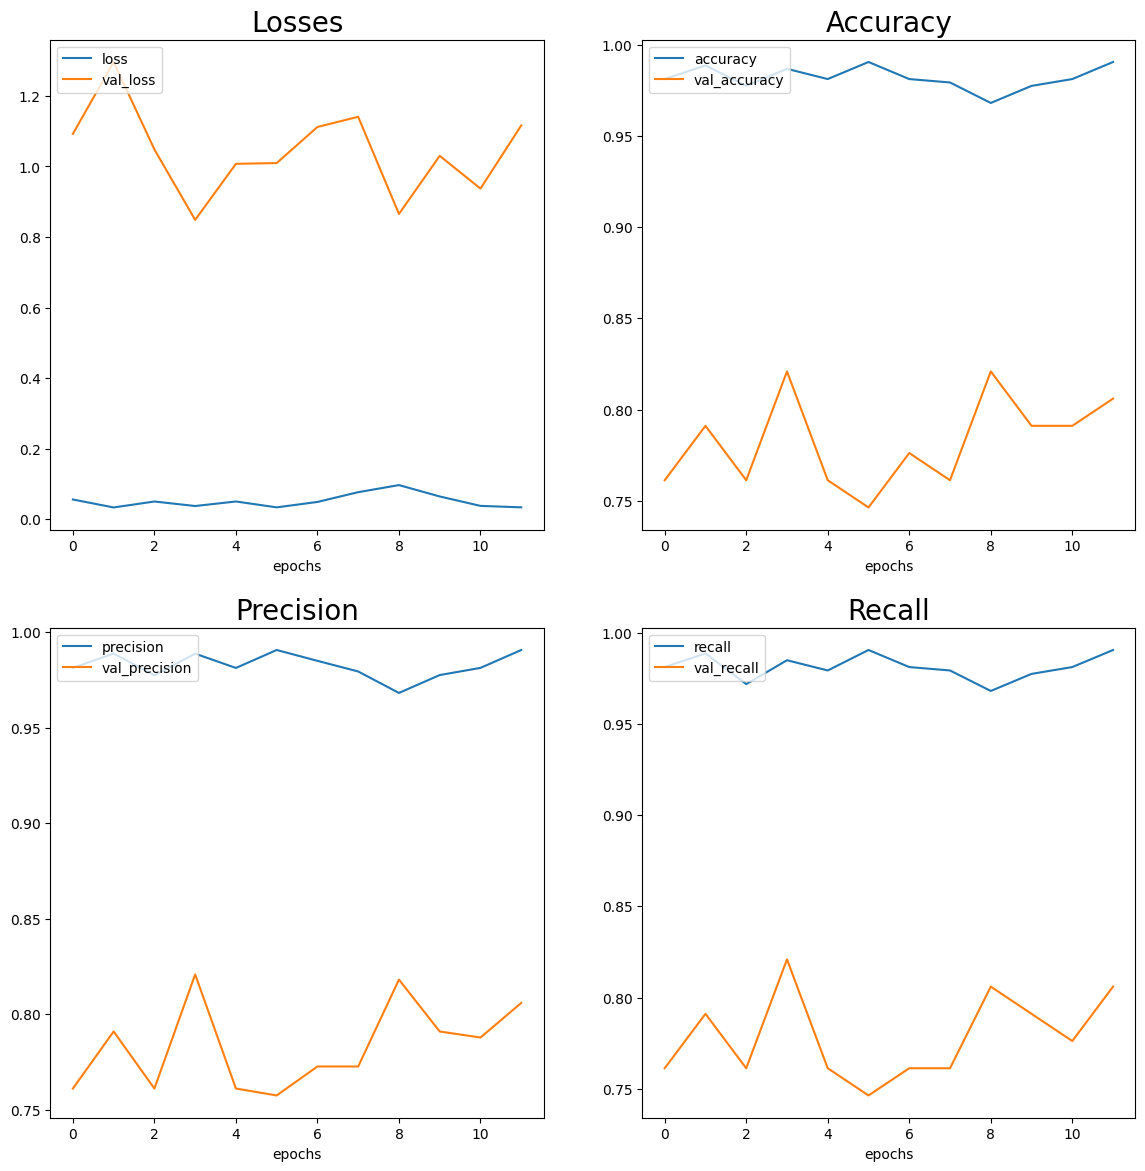

In [22]:
plt.figure(figsize= (14, 14))

plt.subplot(2,2,1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,3)
plt.plot(hist.history['precision_2'], label='precision')
plt.plot(hist.history['val_precision_2'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,4)
plt.plot(hist.history['recall_2'], label='recall')
plt.plot(hist.history['val_recall_2'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()

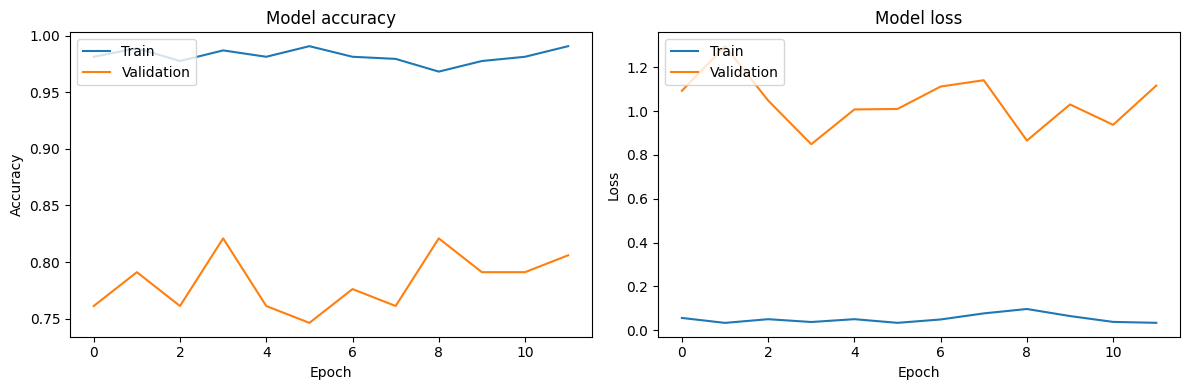

In [37]:
import matplotlib.pyplot as plt

#Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

7. Evaluate

In [23]:
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 568ms/step - accuracy: 1.0000 - loss: 3.3514e-04 - precision_2: 1.0000 - recall_2: 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.8485 - loss: 0.8274 - precision_2: 0.8485 - recall_2: 0.8485
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.8040 - loss: 0.9609 - precision_2: 0.8040 - recall_2: 0.8040
Train Loss:  0.0003888139617629349
Train Accuracy:  1.0
--------------------
Validation Loss:  1.0217957496643066
Validation Accuracy:  0.8059701323509216
--------------------
Test Loss:  0.8501390814781189
Test Accuracy:  0.8208954930305481


In [24]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  


In [25]:
print(classification_report(ts_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       anger       0.92      0.88      0.90        26
       happy       0.72      0.95      0.82        19
         sad       0.82      0.64      0.72        22

    accuracy                           0.82        67
   macro avg       0.82      0.82      0.81        67
weighted avg       0.83      0.82      0.82        67



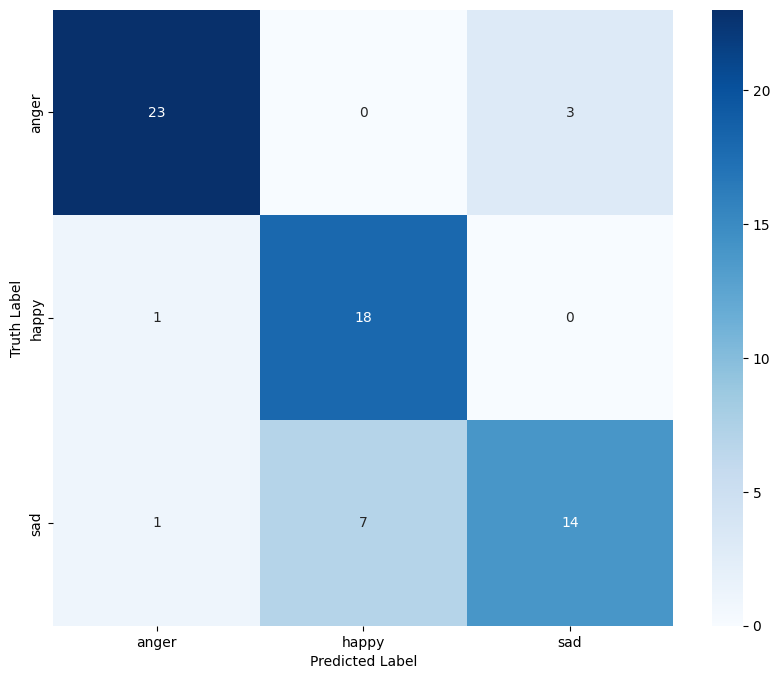

In [26]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(g_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [27]:
model.save("model.h5")

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Load the model
model = tf.keras.models.load_model('model.h5')

# Load and preprocess the image
img_path = 'nangisss.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Scale if your model was trained on normalized images

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Output the result
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: [2]


In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Load the model
model = tf.keras.models.load_model('model.h5')

# Load and preprocess the image
img_path = 'happy.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Scale if your model was trained on normalized images

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Output the result
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: [2]


In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Load the model
model = tf.keras.models.load_model('model.h5')

# Load and preprocess the image
img_path = 'marah.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Scale if your model was trained on normalized images

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Output the result
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: [2]


Jumlah sampel per kelas:
 Class
happy    184
sad      183
anger    167
Name: count, dtype: int64


<Axes: title={'center': 'Distribusi Kelas'}, xlabel='Class'>

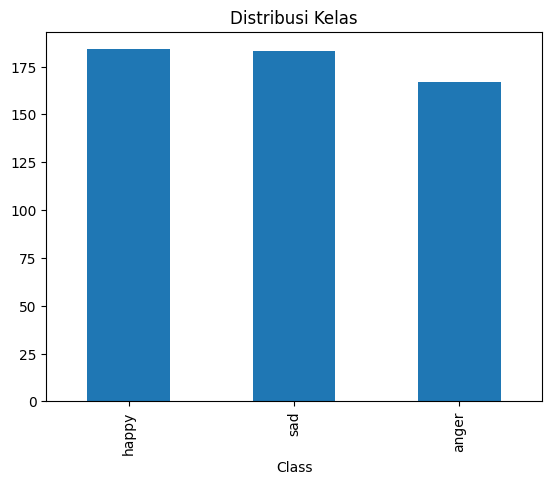

In [35]:
import pandas as pd

# Misalkan data kelas disimpan dalam kolom 'Class' pada DataFrame
class_counts = tr_df['Class'].value_counts()
print("Jumlah sampel per kelas:\n", class_counts)

# Visualisasi menggunakan bar chart
class_counts.plot(kind='bar', title="Distribusi Kelas")

In [41]:
def load_data():
    base_dir = './logs'
    training_path = os.path.join(base_dir, 'train')
    validation_path = os.path.join(base_dir, 'validation')

    train_data = train_df(training_path)
    val_data = train_df(validation_path)

    return train_data, val_data

train_data, val_data = load_data()

# Display first few rows of the training data
train_data.head()

NotADirectoryError: [WinError 267] The directory name is invalid: './logs\\train\\events.out.tfevents.1729999596.ALINNAR.16132.0.v2'